In [6]:
#import all the required libraries
import numpy as np
import pandas as pd
import pickle
from statistics import mode
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention

from tensorflow.keras.callbacks import EarlyStopping

import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# import io
# from google.colab import files
# uploaded = files.upload()


In [63]:
# Parse the Data
# We’ll take a sample of 100,000 row to reduce the training time of our model.

#read the dataset file for text Summarizer

# df = pd.read_csv(io.BytesIO(uploaded["final_data.csv"]),nrows=500)
df=pd.read_csv("final_data.csv",nrows=200000)

#drop the duplicate and na values from the records
df.drop_duplicates(subset=['Text'],inplace=True)

df.dropna(axis=0,inplace=True) #dropping na

input_data = df.loc[:,'Text'].astype("str")
target_data = df.loc[:,'Summary'].astype("str")
target_data.replace('', np.nan, inplace=True)



In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162841 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162841 non-null  int64 
 1   Summary     162841 non-null  object
 2   Text        162841 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


In [65]:
df['Summary'][:0]

Series([], Name: Summary, dtype: object)

In [66]:
text =df['Text'][:1]
print(text)

0    I have bought several of the Vitality canned d...
Name: Text, dtype: object


## **Preprocessing**

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [67]:

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [68]:
# We can use the contraction using two method, one we can use the above dictionary or we can keep the contraction file as a data set and import it. 

In [69]:
input_texts=[]  # Text column
target_texts=[] # summary column
input_words=[]
target_words=[]
# contractions=pickle.load(open("../input/contraction/contractions.pkl","rb"))['contractions']
contractions = contraction_mapping

#initialize stop words and LancasterStemmer
stop_words=set(stopwords.words('english'))
stemm=LancasterStemmer()

# Data Cleaning

In [70]:
def clean(texts,src):
  texts = BeautifulSoup(texts, "lxml").text   #remove the html tags
  words=word_tokenize(texts.lower())  #tokenize the text into words 
  #filter words which contains \ 
  #integers or their length is less than or equal to 3
  words= list(filter(lambda w:(w.isalpha() and len(w)>=3),words))
  #contraction file to expand shortened words
  words= [contractions[w] if w in contractions else w for w in words ]

  #stem the words to their root word and filter stop words
  if src=="inputs":
    words= [stemm.stem(w) for w in words if w not in stop_words]
  else:
    words= [w for w in words if w not in stop_words]
  return words

In [71]:
#pass the input records and target records
for in_txt,tr_txt in zip(input_data,target_data):
  in_words= clean(in_txt,"inputs")
  input_texts+= [' '.join(in_words)]
  input_words+= in_words
  #add 'sos' at start and 'eos' at end of text
  tr_words= clean("sos "+tr_txt+" eos","target")
  target_texts+= [' '.join(tr_words)]
  target_words+= tr_words

In [72]:
#store only unique words from input and target list of words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words
 
#get the length of the input and target texts which appears most often  
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])
 
print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)

number of input words :  45269
number of target words :  19633
maximum input length :  63
maximum target length :  17


# Split it


In [73]:
#split the input and target text into 80:20 ratio or testing size of 20%.
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=0) 

In [74]:
y_train[:10]

['sos best dark roast far eos',
 'sos tastes great works wonders eos',
 'sos loved eos',
 'sos great tea eos',
 'sos nice change regular version eos',
 'sos safe natural eos',
 'sos soo cool eos',
 'sos excellent nutrition great taste eos',
 'sos one favorite ramen eos',
 'sos actually tastes good eos']

In [75]:
x_train[:100]

['pretty picky com coff tri everyth stand weak blend lik dark roast extr bold us drink timothy par night midnight mag green mountain dark mag med wat select get strong enough brew barist prim french roast larg wat set ev extr wat perfect littl pricy oth wor plu get ful cup coff brew larg wat set also ment us filt wat brew coff mak hug diff filt wat barist prim french roast far blow everyth els wat noth els comp lik real dark smoo flav coff must try disappoint keep mind peopl tru lik darkest roast think curl hair sery coff drink',
 'tast good drink on giv energy fiv hour best tak morn much bet drink entir energy drink',
 'big dark chocol fan definit simpl plain oat granol load dark chocol lik dark chocol good antioxid just extr carb plu tast on warn stuff messy op right com hot up truck put fridg op would tak trail reason get heat indo granol good stuff',
 'tea good quit good mighty leaf good would buy',
 'found tasty altern regul raisin bran flak crunchy crunchy raisin bran crunch vert

In [76]:
#train the tokenizer with all the words
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)
 
#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train) 
y_train= tr_tokenizer.texts_to_sequences(y_train)

In [77]:
#pad array of 0's if the length is less than the maximum length 
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')
 
#decoder input data will not include the last word 
#i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

# Model Building

In [78]:
K.clear_session() 
latent_dim = 500
 
#create input object of total number of encoder words
en_inputs = Input(shape=(max_in_len,)) 
en_embedding = Embedding(num_in_words+1, latent_dim)(en_inputs) 

In [79]:
#create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
#encoder states
en_states= [state_h3, state_c3]

# Decoder

In [80]:
# Decoder. 
dec_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tr_words+1, latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs) 
 
#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 

# Attention Layer

In [81]:
#Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])
 
#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

In [82]:
#Dense layer (output layer)
dec_dense = Dense(num_tr_words+1, activation='softmax') 
dec_outputs = dec_dense(merge)

# Train the Model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 63)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 63, 500)      22635000    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 63, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

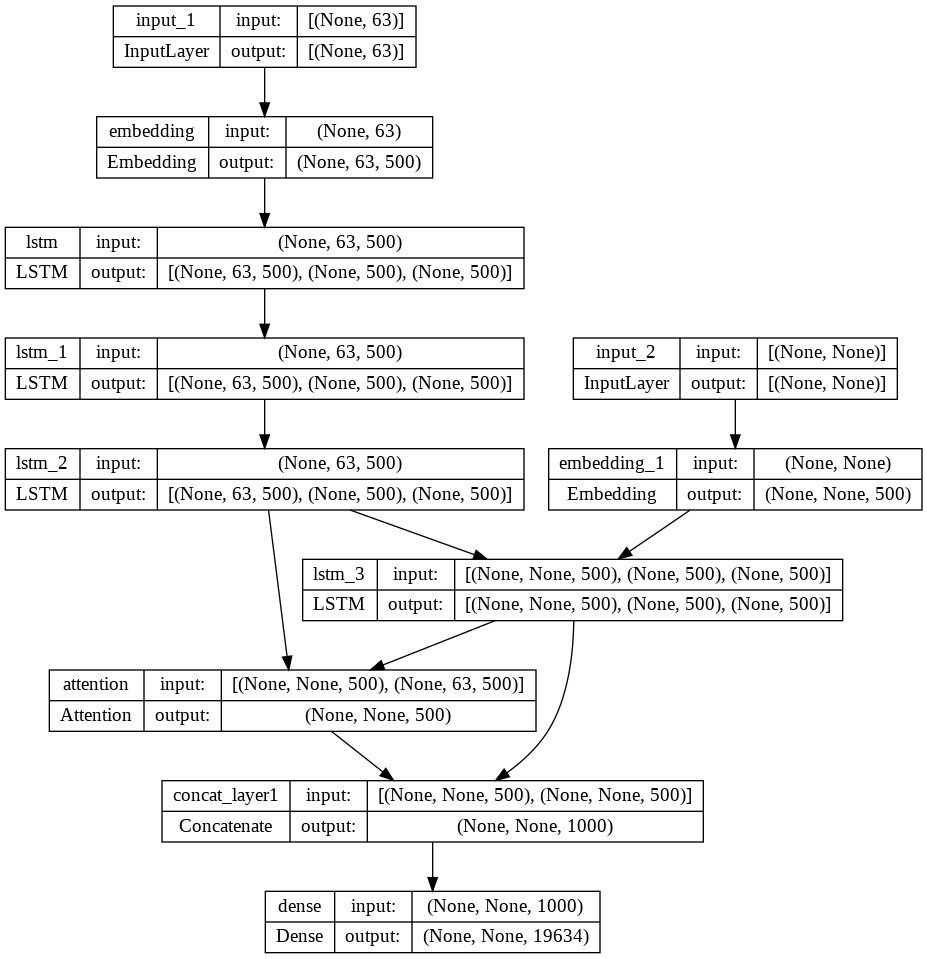

In [83]:
#Model class and model summary for text Summarizer
model = Model([en_inputs, dec_inputs], dec_outputs) 
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [84]:



def precision_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [85]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy",precision_score,recall_score,f1_score] ) 


history = model.fit( 
                    [en_in_data, dec_in_data],
                    dec_tr_data, 
                    batch_size=512, 
                    epochs=10, 
                    validation_split=0.1)

Epoch 1/10
229/229 [==============================] - 198s 837ms/step - loss: 1.4128 - accuracy: 0.8218 - precision_score: 79372877824.0000 - recall_score: 140.6215 - f1_score: 70.0986 - val_loss: 1.2283 - val_accuracy: 0.8353 - val_precision_score: 37.6637 - val_recall_score: 134.0529 - val_f1_score: 58.8006
Epoch 2/10
229/229 [==============================] - 195s 851ms/step - loss: 1.1792 - accuracy: 0.8374 - precision_score: 39.8918 - recall_score: 138.3963 - f1_score: 61.9244 - val_loss: 1.1536 - val_accuracy: 0.8389 - val_precision_score: 36.4974 - val_recall_score: 128.0018 - val_f1_score: 56.7944
Epoch 3/10
229/229 [==============================] - 195s 850ms/step - loss: 1.1090 - accuracy: 0.8406 - precision_score: 36.8515 - recall_score: 128.5734 - f1_score: 57.2776 - val_loss: 1.1189 - val_accuracy: 0.8411 - val_precision_score: 31.1245 - val_recall_score: 111.5678 - val_f1_score: 48.6668
Epoch 4/10
229/229 [==============================] - 195s 852ms/step - loss: 1.0569 

In [86]:
# save model
model.save('Text_Summarizer.h5')
print('Model Saved!')

Model Saved!


In [87]:
history = history.history

{'loss': [1.4128341674804688,
  1.17915940284729,
  1.1090277433395386,
  1.056905746459961,
  1.0131001472473145,
  0.9758590459823608,
  0.9415757656097412,
  0.9082536101341248,
  0.8752805590629578,
  0.8423458933830261],
 'accuracy': [0.8217968344688416,
  0.8373845219612122,
  0.840603768825531,
  0.8433747291564941,
  0.8456850647926331,
  0.8476451635360718,
  0.8495818376541138,
  0.8515510559082031,
  0.8535922169685364,
  0.8560389876365662],
 'precision_score': [79372877824.0,
  39.891822814941406,
  36.85147476196289,
  35.13787841796875,
  34.294979095458984,
  34.091068267822266,
  33.988468170166016,
  33.778114318847656,
  33.744667053222656,
  33.5595588684082],
 'recall_score': [140.62147521972656,
  138.3963165283203,
  128.5734100341797,
  123.17208099365234,
  120.59262084960938,
  120.15494537353516,
  120.04592895507812,
  119.56629180908203,
  119.66924285888672,
  119.22136688232422],
 'f1_score': [70.09857940673828,
  61.92438507080078,
  57.27762985229492,
 

In [108]:
from matplotlib import pyplot


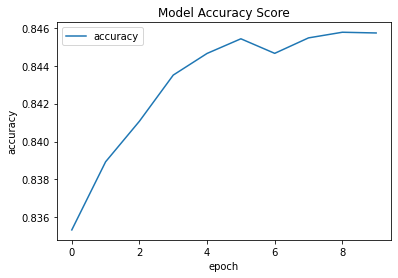

In [111]:
pyplot.plot(history['val_accuracy'])
pyplot.title('Model Accuracy Score')
pyplot.ylabel('accuracy') 
pyplot.xlabel('epoch')
pyplot.legend(['accuracy'], loc='upper left')
pyplot.show()

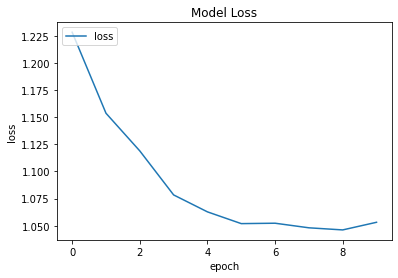

In [112]:
pyplot.plot(history['val_loss'])
pyplot.title('Model Loss')
pyplot.ylabel('loss') 
pyplot.xlabel('epoch')
pyplot.legend(['loss'], loc='upper left')
pyplot.show()

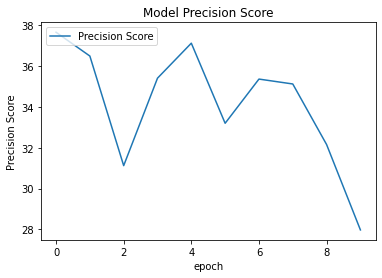

In [113]:
pyplot.plot(history['val_precision_score'])
pyplot.title('Model Precision Score')
pyplot.ylabel('Precision Score') 
pyplot.xlabel('epoch')
pyplot.legend(['Precision Score'], loc='upper left')
pyplot.show()

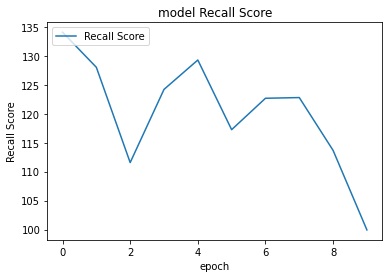

In [114]:
pyplot.plot(history['val_recall_score'])
pyplot.title('model Recall Score')
pyplot.ylabel('Recall Score') 
pyplot.xlabel('epoch')
pyplot.legend(['Recall Score'], loc='upper left')
pyplot.show()

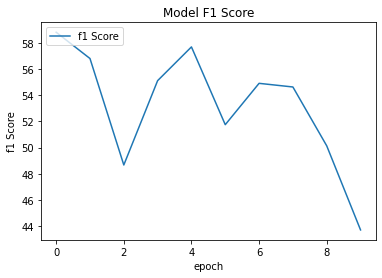

In [115]:
pyplot.plot(history['val_f1_score'])
pyplot.title('Model F1 Score')
pyplot.ylabel('f1 Score') 
pyplot.xlabel('epoch')
pyplot.legend(['f1 Score'], loc='upper left')
pyplot.show()